# Visualize and Analyze Data

This notebook will explore the data we downloaded in the `Customize and Access Data` notebook to fulfill the final objective of this tutorial: 

* Interact with ICESat-2 and MODIS data using basic Python science libraries to visualize, filter, and plot concurrent data.

We will perform the following steps:

1. Read in ATL07 and ATL10 data; apply time and along track distance calculations
3. Read in MOD29 data and apply scale factor 
4. Overlay ATL07 data over MOD29
5. Extract MODIS Ice Surface Temperature (IST) values along ATL07 heights
6. Plot MODIS IST and ICESat-2 heights
7. Plot ATL07 and ATL10 and compare ATL10 coverage with ATL07 quality variables
   

### Import packages

In [1]:
from collections import defaultdict
from osgeo import gdal, osr
import math
import h5py
import xarray as xr
import pyproj
import pandas as pd
from shapely.geometry import Point,Polygon
import pyresample as prs
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import hvplot.pandas  # Adds the 'hvplot' method to pandas objects
import hvplot.xarray  # Adds the 'hvplot' method to xarray objects
import rasterio
import numpy as np
from holoviews.operation.datashader import datashade
import datashader.geo
# to make sure we find the shell from ! cells
import os
os.environ["PATH"] += os.pathsep + os.pathsep.join(['/bin', '/bin/bash'])

# Helper functions
import tutorial_helper_functions as fn

%matplotlib inline

In [ ]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

## Read in ATL07 and ATL10 and perform calculations

We will be focusing on two packages to read in our data:

* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html)
    * Pandas is built on top of NumPy and provides easy to work with data structures. The pandas dataframe is a 2-D tabular data structure with labeled axes. 
* [Xarray](http://xarray.pydata.org/en/stable/index.html)
    * Designed for multidimensional data. Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays. 

### Load ATL07 and ATL10 granules into dataframes

We will start by defining variables to extract and combine as a single dataframe:

In [2]:
VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg'],
    'ATL10': [
        '/gt1l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt1l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt1l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt1l/freeboard_beam_segment/beam_freeboard/beam_fb_height',
        '/gt2l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt2l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt2l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt2l/freeboard_beam_segment/beam_freeboard/beam_fb_height',
        '/gt3l/freeboard_beam_segment/beam_freeboard/delta_time',
        '/gt3l/freeboard_beam_segment/beam_freeboard/latitude',
        '/gt3l/freeboard_beam_segment/beam_freeboard/longitude',
        '/gt3l/freeboard_beam_segment/beam_freeboard/beam_fb_height'
    ]
}

#### We will use the `load_icesat2_as_dataframe` function from our functions module to load points from our ATL07 and ATL10 files: 

In [3]:
# Load ATL07 granules and combine into single ATL07 dataframe

atl07_1298 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
atl07_1305 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)

atl10_1305 = fn.load_icesat2_as_dataframe('./Outputs/processed_ATL10-01_20190323211343_13050201_002_01.h5', VARIABLES)


atl07 = pd.concat([atl07_1298,atl07_1305]) #concatenate dataframes to use in plot below

atl07_1298.head()

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
0,gt3l,3.857279e+07,0.010683,0.676916,10.098009,1,0.025361,79.999983,151.881138,processed_ATL07-01_20190323101341_12980201_002...
1,gt3l,3.857279e+07,0.012471,0.619781,11.594363,1,0.022021,79.999935,151.881056,processed_ATL07-01_20190323101341_12980201_002...
2,gt3l,3.857279e+07,0.012472,0.507711,10.911974,1,0.019280,79.999888,151.880978,processed_ATL07-01_20190323101341_12980201_002...
3,gt3l,3.857279e+07,0.008859,0.329125,11.597196,1,0.019696,79.999842,151.880901,processed_ATL07-01_20190323101341_12980201_002...
4,gt3l,3.857279e+07,0.014333,0.200405,11.587672,1,0.020255,79.999791,151.880816,processed_ATL07-01_20190323101341_12980201_002...


### Convert ATL07 'delta_time' to utc datetime values

In [4]:
# Add datetime values to each dataframe

data_granules = [atl07_1298, atl07_1305, atl10_1305]

for df in data_granules:
    df['utc_datetime'] = df['delta_time'].apply(fn.convert_delta_time)
    df = df.sort_values(by=['beam', 'utc_datetime'])

# atl07_1298
data_granules[0].head()

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,utc_datetime
0,gt3l,3.857279e+07,0.010683,0.676916,10.098009,1,0.025361,79.999983,151.881138,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:51.029008
1,gt3l,3.857279e+07,0.012471,0.619781,11.594363,1,0.022021,79.999935,151.881056,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:51.029835
2,gt3l,3.857279e+07,0.012472,0.507711,10.911974,1,0.019280,79.999888,151.880978,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:51.030626
3,gt3l,3.857279e+07,0.008859,0.329125,11.597196,1,0.019696,79.999842,151.880901,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:51.031411
4,gt3l,3.857279e+07,0.014333,0.200405,11.587672,1,0.020255,79.999791,151.880816,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:51.032279


### Compute along track distance

The `height_segment_length_seg` variable provides the length of each segment. We need these values to be cumulative so that we can plot against distance.  


In [5]:
from IPython.display import display, HTML

for df in data_granules[0:2]:
    df['add_dist'] = df.groupby(['beam'])['height_segment_length_seg'].cumsum()
    

# same as data_granules[0]
display(HTML(atl07_1298.loc[atl07_1298['beam'] == 'gt1l'].head().to_html()))


,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,utc_datetime,add_dist
230181,gt1l,3.857279e+07,0.012045,0.043003,9.379528,1,0.018945,79.999982,152.232054,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.835434,9.379528
230182,gt1l,3.857279e+07,0.015299,0.026843,9.371373,1,0.019077,79.999946,152.231994,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.836040,18.750900
230183,gt1l,3.857279e+07,0.013423,0.072230,10.736919,1,0.019572,79.999898,152.231911,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.836879,29.487820
230184,gt1l,3.857279e+07,0.011518,0.034719,10.744951,1,0.018614,79.999850,152.231830,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.837701,40.232773
230185,gt1l,3.857279e+07,0.010973,0.018861,10.782303,1,0.019800,79.999806,152.231756,processed_ATL07-01_20190323101341_12980201_002...,2019-03-23 10:39:50.838461,51.015076


## Read in MODIS Ice Surface Temperature file and perform calculations

There were 13 granules returned over our time and area of interest. We can use Earthdata Search to easily visualize the coverage of each granule:
[MODIS Earthdata Search result](https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!)

Let's choose a single MODIS granule to be used in our analysis below. 

Out of the 13 returned, these all have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And after viewing the browse images, this looks to have the best data coverage:

* MOD29.A2019082.0140.006.2019082132036.hdf


### Load the MOD29 file into xarray

In [6]:
# Define local filepath and open as xarray

filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf'

mod29 = xr.open_dataset(filepath)
list(mod29.variables)

['Latitude',
 'Longitude',
 'Sea_Ice_by_Reflectance',
 'Sea_Ice_by_Reflectance_Pixel_QA',
 'Ice_Surface_Temperature',
 'Ice_Surface_Temperature_Pixel_QA']

### Convert calibrated data to Kelvin

Before we plot the ATL07 heights over MODIS IST, we need to convert the Ice_Surface_Temperature values to kelvin. According to the [MOD29 User Guide](https://nsidc.org/data/mod29#title11) the Ice_Surface_Temperature (IST) values are stored as calibrated data. To convert to kelvin, use scale_factor = 0.01 and add_offset = 0.0 in the following equation:

IST = scale_factor × (calibrated data - add_offset)

The valid range for ISTs is 210 K to 313.20 K.

Let's apply this conversion to our xarray:

In [7]:
mod29['Ice_Surface_Temperature'] = mod29['Ice_Surface_Temperature']*(0.01) # Apply calibrated data to kelvin conversion

## Visualize ICESat-2 height values over MODIS Ice Surface Temperature

We can visualize the ICESat-2 track locations and height values overlayed with MODIS Ice Surface Temperature. We should see higher ATL07 heights along fast ice, with lower heights over thin ice and then increasing height over drift ice. We are using the Matplotlib pcolormesh function to plot MOD29 as as 2D array. The ATL07 locations are plotted as a scatter plot. 

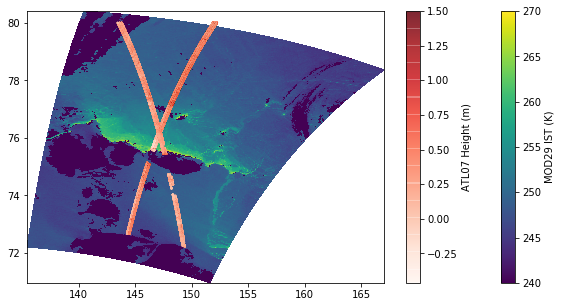

In [8]:
plt.rcParams['figure.figsize'] = [10, 5] # Increase standard figure size
plt.rcParams.update({'font.size': 10}) # Increase font size of axes

plt.pcolormesh(mod29.Longitude, mod29.Latitude, mod29.Ice_Surface_Temperature, vmin=240, vmax=270, cmap='viridis') # Set range to valid IST values
plt.colorbar(label='MOD29 IST (K)')
plt.scatter(atl07.longitude, atl07.latitude,
          c=atl07.height_segment_height, vmax=1.5,
          cmap='Reds', alpha=0.6, s=1)    
plt.colorbar(label='ATL07 Height (m)')
plt.show()

## Extract MODIS IST values along the ICESat-2 tracks

Now that we've visually inspected height and IST values, let's do some analysis. We will now extract MODIS IST values at each ATL07 point.


### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [9]:
icesat2_geometry_1298 = prs.geometry.SwathDefinition(lons=atl07_1298['longitude'], lats=atl07_1298['latitude'])
icesat2_geometry_1305 = prs.geometry.SwathDefinition(lons=atl07_1305['longitude'], lats=atl07_1305['latitude'])

icesat2_geometry_atl10_1305 = prs.geometry.SwathDefinition(lons=atl10_1305['longitude'], lats=atl10_1305['latitude'])

mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])
atl07_1298['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_1298, radius_of_influence=1000, fill_value=np.nan)
atl07_1305['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_1305, radius_of_influence=1000, fill_value=np.nan)
atl10_1305['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_atl10_1305, radius_of_influence=1000, fill_value=np.nan)

We can now apply nan's to the MOD29 land mask value:

In [10]:
# apply nan's to MOD29 land mask

atl07_1298[atl07_1298['mod29_ice_surface_temperature'] == 50] = np.nan
atl07_1305[atl07_1305['mod29_ice_surface_temperature'] == 50] = np.nan
atl10_1305[atl10_1305['mod29_ice_surface_temperature'] == 50] = np.nan

## Plot MODIS IST and ICESat-2 height along tracks
 

### First, we'll plot against time.

ATL07-01_20190323211343_13050201_002_01 is moving from low to high latitude: The start time begins at the fast ice, skips over an island, and moves towards warmer thin ice onto thicker drift ice.

ATL07-01_20190323101341_12980201_002_01 is moving from high to low latitude: The start time begins at the thicker drift ice, moving towards thinner ice and open water, ending at colder fast ice. 

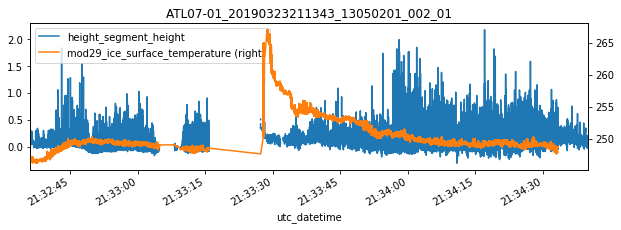

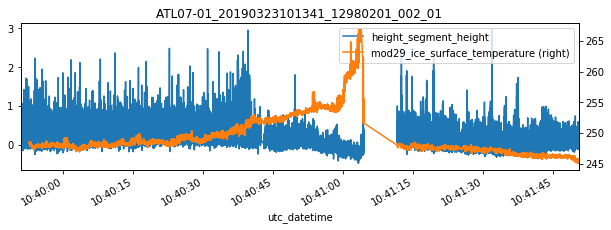

In [11]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(10,3))
atl07_1305.plot(x='utc_datetime', y='height_segment_height', ax=ax)
atl07_1305.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01');

fig, ax = plt.subplots(figsize=(10,3))
atl07_1298.plot(x='utc_datetime', y='height_segment_height', ax=ax)
atl07_1298.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323101341_12980201_002_01');

### Next, let's plot against distance. 

Because each height segment represents a variable distance based on 150 photon returns, this is a more accurate representation of height and IST values across the transect. We'll focus on ICESat-2 track 1298 since this track has fewer data gaps over the islands. Again, this track is moving from high to low latitude: The start distance begins at the thicker drift ice, moving towards thinner ice and open water, ending at colder fast ice. 

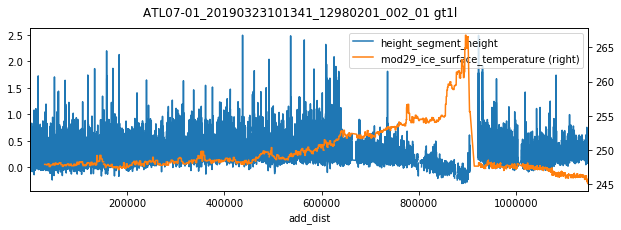

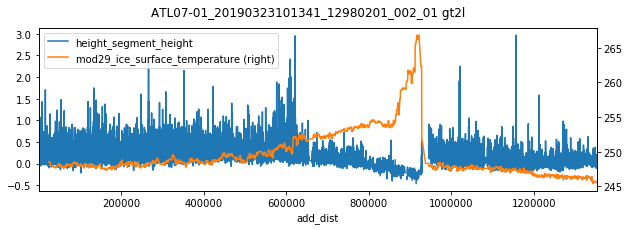

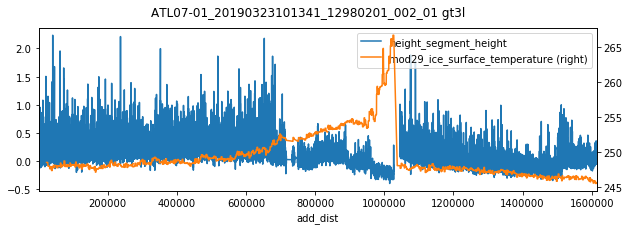

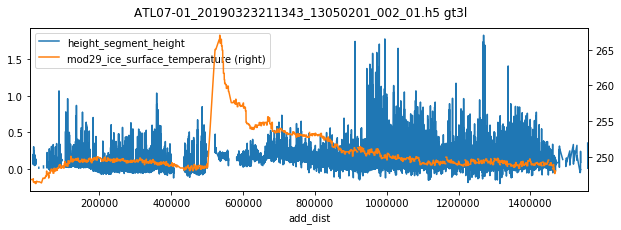

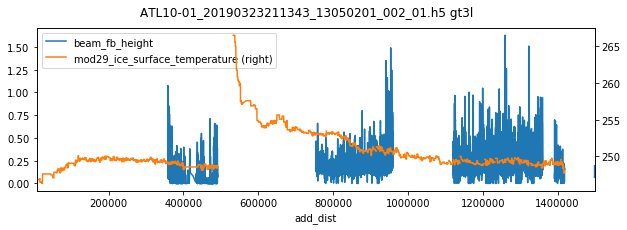

In [12]:
fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('ATL07-01_20190323101341_12980201_002_01 gt1l')
atl07_1298.loc[atl07_1298['beam'] == 'gt1l'].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1298.loc[atl07_1298['beam'] == 'gt1l'].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('ATL07-01_20190323101341_12980201_002_01 gt2l')
atl07_1298.loc[atl07_1298['beam'] == 'gt2l'].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1298.loc[atl07_1298['beam'] == 'gt2l'].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('ATL07-01_20190323101341_12980201_002_01 gt3l')
atl07_1298.loc[atl07_1298['beam'] == 'gt3l'].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1298.loc[atl07_1298['beam'] == 'gt3l'].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True);

# Now let's try ATL07 vs ATL10 for the same segments
fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('ATL07-01_20190323211343_13050201_002_01.h5 gt3l')
atl07_1305.loc[atl07_1305['beam'] == 'gt3l'].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1305.loc[atl07_1305['beam'] == 'gt3l'].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True);

atl10_1305['add_dist'] = atl07_1305['add_dist']
fig, ax = plt.subplots(figsize=(10,3))
fig.suptitle('ATL10-01_20190323211343_13050201_002_01.h5 gt3l')
atl10_1305.loc[atl10_1305['beam'] == 'gt3l'].plot(x='add_dist', y='beam_fb_height', ax=ax)
atl10_1305.loc[atl10_1305['beam'] == 'gt3l'].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True);


Key observations:

* As the drift ice thins, the height is decreasing as IST increases.
* Over fast ice, cold IST with fairly constant and higher ICESat-2 heights.
* Warm IST is seen in open water, with thin ice just off the fast ice boundary

## How does this compare to the ATL10 freeboard data?

## Luis, here are final steps:

1. Read in the ATL10 granules (staged on s3) and apply the same time and distance calculations. Might be quicker for the tutorial to just add those into the ATL07 code blocks above (less shift-entering).

For ATL10, read in:

'/gt1l/freeboard_beam_segment/delta_time',
'/gt1l/freeboard_beam_segment/latitude',
'/gt1l/freeboard_beam_segment/longitude',
'/gt1l/freeboard_beam_segment/beam_fb_height,
'/gt2l/freeboard_beam_segment/delta_time',
'/gt2l/freeboard_beam_segment/latitude',
'/gt2l/freeboard_beam_segment/longitude',
'/gt2l/freeboard_beam_segment/beam_fb_height,
'/gt3l/freeboard_beam_segment/delta_time',
'/gt3l/freeboard_beam_segment/latitude',
'/gt3l/freeboard_beam_segment/longitude',
'/gt3l/freeboard_beam_segment/beam_fb_height,

2. Just using the 1298 track, set up a plot with ATL07 and ATL10 plotted by distance. Just pick one beam to plot. 

3. What we want to show is: How do the ATL07 quality parameters relate to ATL10 coverage? We should see more ATL10 values with better ATL07 quality and visa versa. The plot should be set up to where the participants could interact and plot the three different ATL07 quality parameters:

`height_segment_quality`
`height_segment_confidence`
`height_segment_surface_error_est`

    
I started to do this below against the MODIS IST data but I think it's best to focus on comparing ATL07 and ATL10 without MODIS. 

### Data filtering by quality flag

We'll compare data before and after applying the quality flags we subsetted. Let's start by filtering `/sea_ice_segments/heights/height_segment_height` based on `/sea_ice_segments/heights/height_segment_quality` for each beam group. According to the [User Guide](https://nsidc.org/data/ATL07#title38):

height_segment_quality: a binary indicator (1 = good, 0 = bad) of segment quality

In [ ]:
cond = {'beam': 'gt1l', 'height_segment_quality': 1}
fig, ax = plt.subplots(figsize=(10,3))
atl07_1298.loc[(atl07_1298.beam == cond['beam']) & (atl07_1298.height_segment_quality == cond['height_segment_quality'])].plot(x='add_dist', y='height_segment_height', ax=ax)
atl07_1298.loc[(atl07_1298.beam == cond['beam']) & (atl07_1298.height_segment_quality == cond['height_segment_quality'])].plot(x='add_dist', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)
plt.title('ATL07-01_20190323211343_13050201_002_01 gt1l filtered');

What should we see above?

* If we use IST = 271.2 K for open water and then find the IST at the first valid ATL10 value, we have the IST value at that freeboard. Then we can use that relationship to get thin ice freeboard where there is ATL07 data, but not ATL10
* Comparing data with and without quality flag, the high temps are getting filtered out - more open water.